# Equation Rendering

Equation Rendering notebook 

Notebook by Martijn de Vries <br>
martijndevries91@gmail.com

In [446]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import sys
import tensorflow as tf
import jellyfish

from IPython.display import display, Latex

from tensorflow.keras.preprocessing.image import smart_resize

from importlib import reload 
import resolve_symbols
import render_equations

In [447]:
reload(resolve_symbols) #debugging
reload(render_equations)
from resolve_symbols import resolve_symbols_on_img
from render_equations import render_equation

Load in class labels from class_names.txt 

In [448]:
with open('../class_names.txt', 'r') as f:
    lines = f.readlines()
class_labels = [label.split(' ')[-1][:-1] for label in lines]

Load in the model

In [449]:
efficientnet_model = tf.keras.models.load_model('../CNN_model/efficientnet_model.h5')

Some images to test the rendering on

In [435]:
full_eq_imgs = glob.glob('../img_data/full_equations/*png')

Now let's write a function to actually make a prediction with the efficientnet model

In [450]:
def make_predictions(symbol_list, extend_list):

    pred_list = []
    pred_symbol_list, pred_idx_list = [], []
    for i, symbol in enumerate(symbol_list):

        rgb_im = np.zeros((symbol.shape[0], symbol.shape[1], 3))
        for j in range(3):
            rgb_im[:,:,j] = symbol.astype('uint8')
        resize_img = smart_resize(rgb_im, (120,120))
        resize_img = np.expand_dims(resize_img, axis=0)
        prediction = efficientnet_model.predict(resize_img, verbose=0)
    
        pred_dic = {k[6:]:v for v,k in sorted(zip(prediction[0], class_labels))[-4:]}
        y_classes = prediction.argmax(axis=-1)
        pred_idx_list.append(y_classes)
        label = class_labels[y_classes[0]][6:]
        
        #check if a symbol extends over multiple adjacent symbols
        #if it's not a square root, check if the square root is predicted at a lower probability
        #if so, just use that
        if extend_list[i] >  1 and label != '\\sqrt':
            if '\\sqrt' in pred_dic.keys(): 
                label = '\\sqrt'
        
            
        pred_symbol_list.append(label)
        pred_list.append(pred_dic)
    return pred_symbol_list

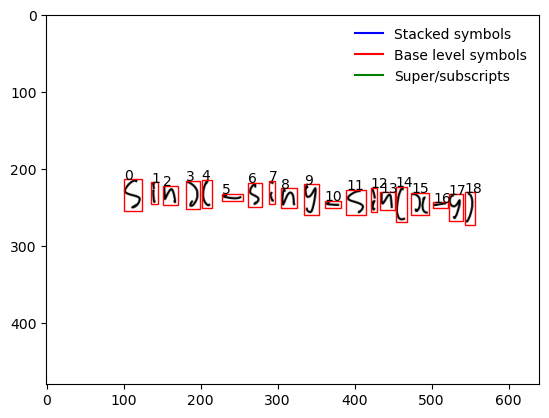

In [39]:
img_idx = 190
symbs, levels, stack, script_levels, extend_list, ax = resolve_symbols_on_img(full_eq_imgs[img_idx])

pred_symbol_list = make_predictions(symbs, extend_list)
eqstr = render_equation(pred_symbol_list, levels, stack, script_levels, extend_list)

In [40]:
display(Latex(eqstr))

<IPython.core.display.Latex object>

In [41]:
eqstr

'$ \\sin ) ( - \\sin y - \\sin ( x - y )$'

### Evaluating the performance of the full pipeline

Now that the full pipeline is working, we want to know how well it does at actually predicting the equation label.
In order to gauge this, we will use the 'damerau-levenshtein distance', which measures how many symbols in two strings are different or need to be transposed

First let's retrieve the images we want to predict on

In [356]:
full_eq_imgs_eval = []
eq_dir = '../img_data/full_equations/'
for i in range(1000):
    full_eq_imgs_eval.append(eq_dir + 'full_eq_' + str(i) + '.png')

And load in the corresponding equation labels

In [357]:
#equation labels
with open(eq_dir + 'eq_labels.txt') as f:
    full_labels = f.readlines()
full_labels = [label[:-2] for label in full_labels]

In [358]:
comp_l = ['\\sum', '\\lim']
lim_labels = [label for label in full_labels if comp_l[0] in label or comp_l[1] in label]
trig_l = ['\\cos', '\\tan', '\\sin']
trig_labels = [label for label in full_labels if (trig_l[0] in label or trig_l[1] in label or trig_l[2] in label) and label not in lim_labels]


In order to make sure my equation strings and the labels look as similar as possible, I 'reprocess' the equation labels. One example of why this is necessary is that in the equation labels, if a single symbol is in a super or subscript ('^' or '_'), the symbol will somtimes not have curly brackets around them. While in my equation rendering function, it will.

In [451]:
def reprocess_eq(input_eq):
    """
    Reprocess the equation label, so that the comparison with the predicted equation label can be made
    Because I'm using the demerau-levenshtein distance to compare the predicted and actual equation strings
    it's important that the two are formatted as similarly as possible
    Input:
        equation string, read in from eq_labels.txct
    Returns:
        reprocessed equation string
    """
    
    #remove all whitespace and math mode markings ($), and make sure brackets are always labeled the same way
    input_eq = input_eq.replace(' ','').replace('$', '').replace('\left(','(').replace('right)',')').replace('\)',')').replace('\(','(')
    
    #add curly brackets around superscripts and subscripts
    br_ct = 0
    idx_l = []
    
    #first count how many instances of ^ and _ NOT followed by a curly bracket there are
    ss_list = ['^', '_']
    for i,s in enumerate(input_eq[:-1]):
        if s in ss_list and input_eq[i+1] != '{':
            idx_l.append(i+1)
            br_ct += 1
        
    #then rewrite the string piece by piece, adding curly opening and closing brackets where necessary
    input_eq_n = ''
    p = 0
    at_end = False
    for i in range(br_ct):

        input_eq_n += input_eq[p:idx_l[i]] + '{' + input_eq[idx_l[i]] + '}'
        if idx_l[i] == len(input_eq) - 1:
            at_end = True
        if at_end == False:
            p = idx_l[i]+1
            
    if at_end == False:
        input_eq_n += input_eq[p:]
    return input_eq_n

Now let's go through the full pipeline, and calculate the levenshtein-damerau distance between the predicted and actual equation strings

In [452]:
lvs_n, lvs_c, lvs_t = [],[],[]
lvs_a = []
for a in range(1000):
    if a%50==0:print(a)
    symbs, levels, stack, script_levels, extend_list = resolve_symbols_on_img(full_eq_imgs_eval[a], plot=False)
    pred_symbol_list = make_predictions(symbs, extend_list)
    eqstr = render_equation(pred_symbol_list, levels, stack, script_levels, extend_list)
    
    predicted_eq = eqstr.replace(' ','').replace('$', '')
    actual_eq = reprocess_eq(full_labels[a])

    dl_dist = jellyfish.damerau_levenshtein_distance(predicted_eq, actual_eq)/len(actual_eq)
    if full_labels[a] in lim_labels:
        lvs_c.append(dl_dist)
    elif full_labels[a] in trig_labels:
        lvs_t.append(dl_dist)
    else:
        lvs_n.append(dl_dist)
    lvs_a.append(dl_dist)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


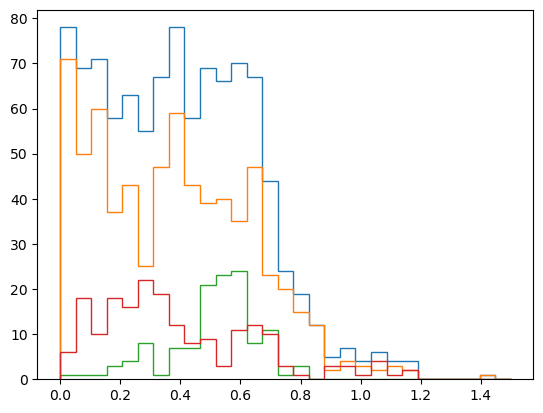

In [453]:
lbins = np.linspace(0, 1.5, 30)
plt.hist(lvs_a, bins=lbins, histtype='step')
plt.hist(lvs_n, bins=lbins, histtype='step')
plt.hist(lvs_c, bins=lbins, histtype='step')
plt.hist(lvs_t, bins=lbins, histtype='step')

plt.show()

In [454]:
def print_dist_info(input_dists):
    print('-' * 30)
    i_a = np.array(input_dists)
    p_0 = len(i_a[i_a == 0])/len(i_a)
    p_10 = len(i_a[i_a < 0.1])/len(i_a)
    p_25 = len(i_a[i_a < 0.25])/len(i_a)
    p_50 = len(i_a[i_a < 0.5])/len(i_a)

    print('perfect predictions:', p_0)
    print('normalized dist <0.1', p_10)   
    print('normalized dist <0.25', p_25)
    print('normalized dist <0.5', p_50)
    return

In [457]:
dists_l = [lvs_a, lvs_n, lvs_t, lvs_c]
for d in dists_l:
    print_dist_info(d)

------------------------------
perfect predictions: 0.058
normalized dist <0.1 0.13
normalized dist <0.25 0.327
normalized dist <0.5 0.622
------------------------------
perfect predictions: 0.07602339181286549
normalized dist <0.1 0.1564327485380117
normalized dist <0.25 0.37280701754385964
normalized dist <0.5 0.6578947368421053
------------------------------
perfect predictions: 0.026041666666666668
normalized dist <0.1 0.109375
normalized dist <0.25 0.3333333333333333
normalized dist <0.5 0.6875
------------------------------
perfect predictions: 0.008064516129032258
normalized dist <0.1 0.016129032258064516
normalized dist <0.25 0.06451612903225806
normalized dist <0.5 0.3225806451612903


In [440]:
dists_l = [lvs_a, lvs_n, lvs_t, lvs_c]
for d in dists_l:
    print_dist_info(d)

------------------------------
perfect predictions: 0.089
normalized dist <0.1 0.126
normalized dist <0.25 0.255
normalized dist <0.5 0.587
------------------------------
perfect predictions: 0.12280701754385964
normalized dist <0.1 0.16812865497076024
normalized dist <0.25 0.3201754385964912
normalized dist <0.5 0.6374269005847953
------------------------------
perfect predictions: 0.026041666666666668
normalized dist <0.1 0.052083333333333336
normalized dist <0.25 0.140625
normalized dist <0.5 0.546875
------------------------------
perfect predictions: 0.0
normalized dist <0.1 0.008064516129032258
normalized dist <0.25 0.07258064516129033
normalized dist <0.5 0.3709677419354839


In [377]:
idxs = np.where(lvs_a > 0.6)[0]

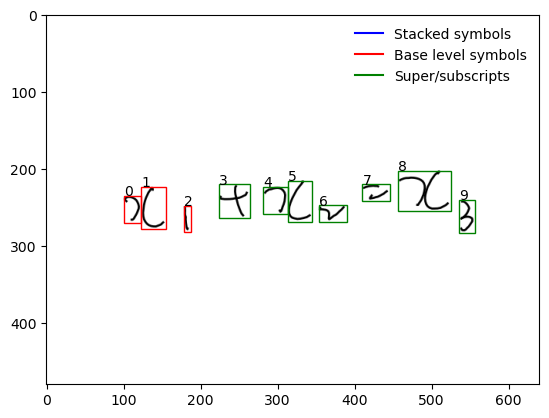

In [378]:
symbs, levels, stack, script_levels, extend_list, ax  = resolve_symbols_on_img(full_eq_imgs_eval[266], plot=True)
pred_symbol_list = make_predictions(symbs, extend_list)
eqstr = render_equation(pred_symbol_list, levels, stack, script_levels, extend_list)

In [379]:
eqstr

'$ x 1^{ +  k  2^{ =  x} 3}$'

154


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

PREDICTED EQ: \alphan+1^{-\beta=}23}+\beta\sqrt{3\beta
ACTUAL EQ: \alpha_{n+1}-3\beta=\frac{2}{3}\alpha_{n}+\beta-3\beta
0.5185185185185185
------------------------------
164


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

PREDICTED EQ: (x^{3}-x^{2}-x)(H-7)
ACTUAL EQ: (x^{3}-x^{2}-x)(2x-7)
0.09523809523809523
------------------------------
168


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

PREDICTED EQ: a+b_{+c+d+e}
ACTUAL EQ: a+b+c+d+e
0.3333333333333333
------------------------------
184


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

PREDICTED EQ: \alpha_{m\pi1}-3\beta=\frac{2}{3}\alpha_{n}+\beta-3\beta
ACTUAL EQ: \alpha_{n+1}-3\beta=\frac{2}{3}\alpha_{n}+\beta-3\beta
0.07407407407407407
------------------------------
190


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

PREDICTED EQ: x_{u}-x_{n+1}+x_{-+2}
ACTUAL EQ: x_{i}-x_{i+1}+x_{i+2}
0.14285714285714285
------------------------------


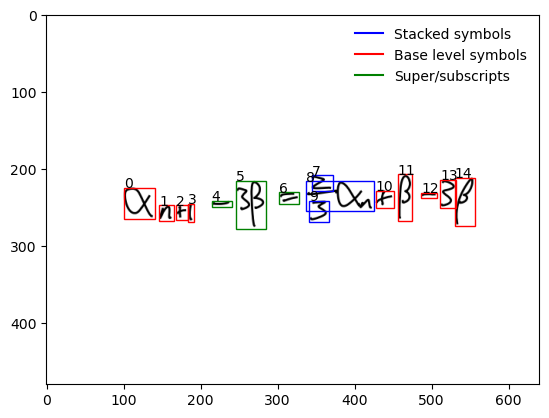

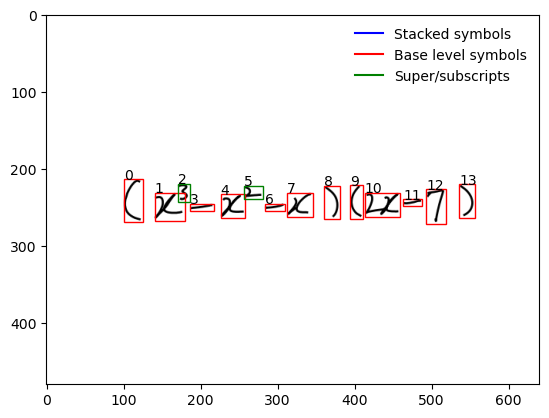

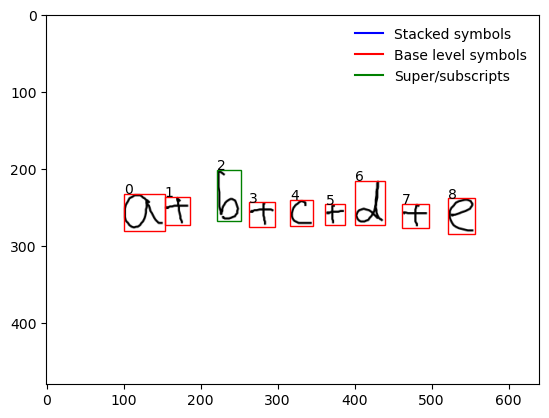

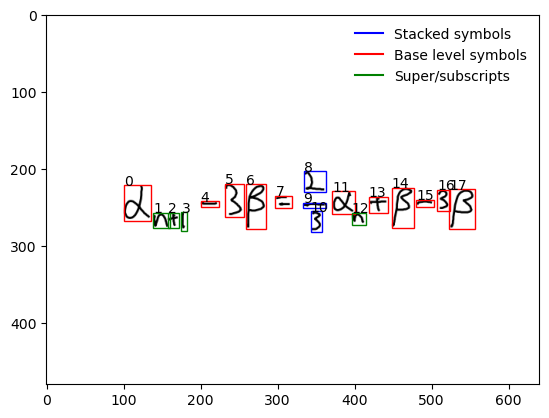

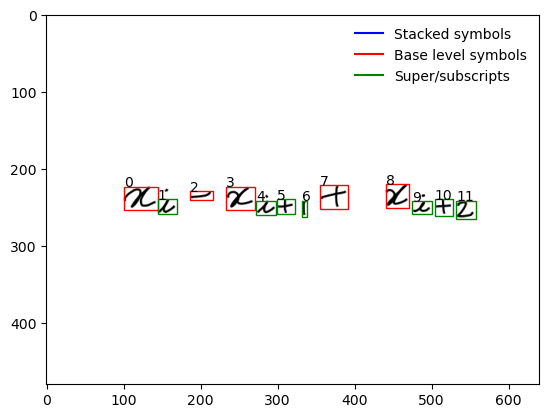

In [380]:
for a in idxs[25:30]:
    print(a)
    #if a%50==0:print(a)
    symbs, levels, stack, script_levels, extend_list, ax  = resolve_symbols_on_img(full_eq_imgs_eval[a], plot=True)
    pred_symbol_list = make_predictions(symbs, extend_list)
    eqstr = render_equation(pred_symbol_list, levels, stack, script_levels, extend_list)
    predicted_eq = eqstr.replace(' ','').replace('$', '')
    actual_eq = reprocess_eq(full_labels[a])
    
    display(Latex(eqstr))
    display(Latex('$' + full_labels[a] + '$'))

    print('PREDICTED EQ:', predicted_eq)
    #print('unprocessed eq:', full_labels[a])
    print('ACTUAL EQ:', actual_eq)
    print(jellyfish.damerau_levenshtein_distance(predicted_eq, actual_eq)/len(actual_eq))
    
    print('-'*30)


In [476]:
pred_symbol_list

['x',
 '1',
 '-',
 'x',
 '2',
 '+',
 'y',
 '(',
 '-',
 'y',
 '3',
 '+',
 'z',
 '1',
 '-',
 'z',
 '2']

In [317]:
print(pred_symbol_list)

['\\gamma', '(', 'capital_X', ')', '=', '\\tan', 'n', '\\rightarrow', '\\infty', 'n', '!', 'n', 'k', '-', '\\times', '(', 'n', '+', '1', 'y']


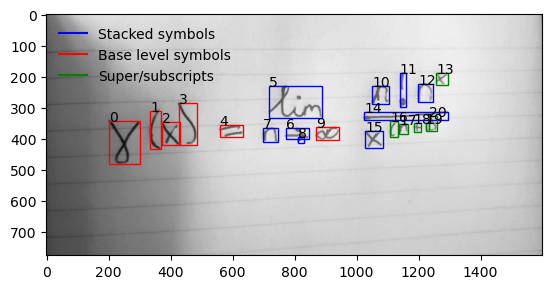

In [444]:
symbs, levels, stack, script_levels, extend_list, ax  = resolve_symbols_on_img('../math_martijn.jpeg', plot=True)
pred_symbol_list = make_predictions(symbs, extend_list)


In [445]:
eqstr = render_equation(pred_symbol_list, levels, stack, script_levels, extend_list)
display(Latex(eqstr))


<IPython.core.display.Latex object>

In [332]:
img_file = '../img_data/train_symbols/label_\\lim/img_3.png'
img = cv2.imread(img_file,cv2.IMREAD_GRAYSCALE)

make_predictions([img], [0])
#symb = o
#for symb in symbs[3:6]:
#    plt.figure()
#    plt.imshow(symb, cmap='gray')

0


['\\lim']

In [355]:
pred_symbol_list

['8',
 '(',
 'capital_X',
 ')',
 '=',
 '\\lim',
 '\\rightarrow',
 'n',
 '1',
 '\\infty',
 'n',
 '!',
 'n',
 'k',
 '-',
 'x',
 '(',
 'n',
 '+',
 '1',
 '\\lambda']

(array([3.95000e+02, 1.12400e+03, 1.80900e+03, 1.59000e+03, 1.83700e+03,
        1.97700e+03, 2.01900e+03, 1.75300e+03, 1.78400e+03, 1.75000e+03,
        2.59000e+03, 3.43700e+03, 4.85600e+03, 6.11500e+03, 7.25200e+03,
        8.85300e+03, 9.17200e+03, 1.08380e+04, 1.23290e+04, 1.77560e+04,
        1.94500e+04, 2.60030e+04, 3.23980e+04, 4.90790e+04, 6.18470e+04,
        8.56900e+04, 9.75960e+04, 1.40878e+05, 1.79397e+05, 6.48426e+05]),
 array([  1.        ,   9.46666667,  17.93333333,  26.4       ,
         34.86666667,  43.33333333,  51.8       ,  60.26666667,
         68.73333333,  77.2       ,  85.66666667,  94.13333333,
        102.6       , 111.06666667, 119.53333333, 128.        ,
        136.46666667, 144.93333333, 153.4       , 161.86666667,
        170.33333333, 178.8       , 187.26666667, 195.73333333,
        204.2       , 212.66666667, 221.13333333, 229.6       ,
        238.06666667, 246.53333333, 255.        ]),
 <BarContainer object of 30 artists>)

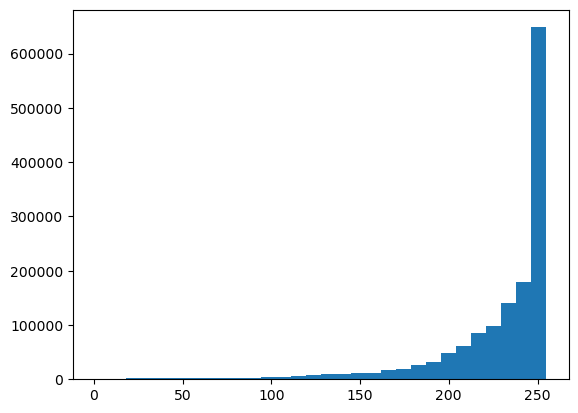

In [238]:
plt.hist(np.ravel(blur), bins=30)

In [383]:
'''
data = [
  [4.9, 3.1, 1.5, 0.1],
  [5.0, 3.2, 1.2, 0.2],
  [5.5, -3.5, 1.3, 0.2],
  [4.9, 3.1, -1.5, 0.1],
  [4.4, 3.0, 1.3, 0.2],
  [5.1, -1, 1.5, 0.2],
  [5.0, 3.5, -1.3, 0.3],
]
# 1. Write a method that returns true if the input dataset has any negative values.
# 2. Write a method to find the most frequent value of the 2nd column in the dataset.
# 3. Write a method that returns all rows of dataset that do not have any negative values.
'''

data = [
  [4.9, 3.1, 1.5, 0.1],
  [5.0, 3.2, 1.2, 0.2],
  [5.5, -3.5, 1.3, 0.2],
  [4.9, 3.1, -1.5, 0.1],
  [4.4, 3.0, 1.3, 0.2],
  [5.1, -1, 1.5, 0.2],
  [5.0, 3.5, -1.3, 0.3],
]



In [394]:
def hasNegative(input_data):
    
    neg_vals = sum([sum([0 if x >= 0 else 1 for x in row]) for row in input_data])
    if neg_vals > 0:
        return True
    else:
        return False

In [395]:
hasNegative(data)

True

In [418]:
def find_mode(input_data):
    col2 = [col[1] for col in input_data]
    mode_dic = {}
    for value in col2:
        if value in mode_dic.keys():
            mode_dic[value] +=1
        else:
            mode_dic[value] = 1
    return max(mode_dic, key=lambda key: mode_dic[key])

In [421]:
md = find_mode(data)

In [429]:
def getPositiveRows(input_data):
    neg_vals = [[0 if x >= 0 else 1 for x in row] for row in input_data]
    return [row for i,row in enumerate(input_data) if sum(neg_vals[i]) == 0]

In [430]:
getPositiveRows(data)

[[4.9, 3.1, 1.5, 0.1], [5.0, 3.2, 1.2, 0.2], [4.4, 3.0, 1.3, 0.2]]